In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import datetime

# Visualization
import matplotlib.pyplot as plt

# Word stemming
from nltk.stem.porter import PorterStemmer

# Stop word
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words("english")

# Wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_s = pd.read_csv("/content/scrubbed.csv", header=0)
df_s.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [ ]:
# data size
df_s.shape

(80332, 11)

In [ ]:
# null value
df_s.isnull().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
dtype: int64

In [ ]:
# unique values
for i in range(df_s.shape[1]):
    print("-"*50)
    print(df_s.columns[i])
    print(df_s.iloc[:,i].value_counts())

--------------------------------------------------
datetime
7/4/2010 22:00      36
7/4/2012 22:00      31
11/16/1999 19:00    27
9/19/2009 20:00     26
7/4/2011 22:00      25
                    ..
11/9/1997 06:15      1
12/16/2011 22:18     1
10/1/2008 09:45      1
5/6/2006 07:45       1
1/12/2012 22:30      1
Name: datetime, Length: 69586, dtype: int64
--------------------------------------------------
city
seattle                                       525
phoenix                                       454
portland                                      374
las vegas                                     368
los angeles                                   353
                                             ... 
ray                                             1
yoza dakke air station&#44 okinawa (japan)      1
fayetteville/new athens                         1
north spokane                                   1
rawtenstall (uk/england)                        1
Name: city, Length: 19900, dtype: int

In [ ]:
# data info
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


In [ ]:
df_s.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [ ]:
lists = []
for i in range(len(df_s["datetime"])):
    k = df_s["datetime"][i].split(" ")[0]
    lists.append(k)

In [ ]:
df_s["date"] = lists

df_s["dt"] = pd.to_datetime(df_s["date"])
df_s["year"] = df_s["dt"].dt.year

In [ ]:
# groupby year
df_year = pd.DataFrame(data=df_s.groupby("year").city.count()).reset_index()
df_year.head()

,year,city
0,1906,1
1,1910,2
2,1916,1
3,1920,1
4,1925,1


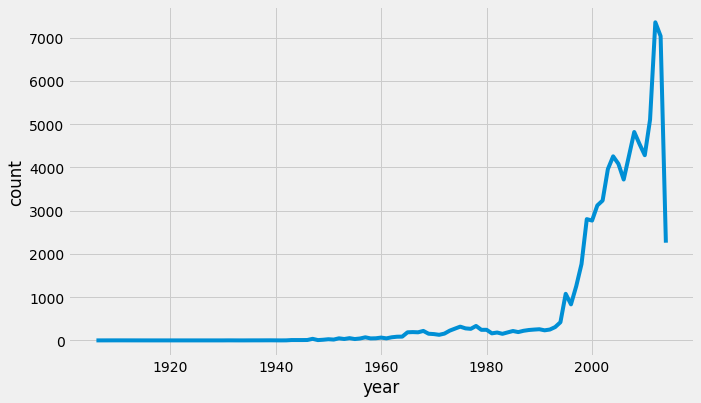

In [ ]:
# visualization
with plt.style.context("fivethirtyeight"):
    plt.figure(figsize=(10,6))
    plt.plot(df_year["year"], df_year["city"])
    plt.xlabel("year")
    plt.ylabel("count")

In [ ]:
# groupby city
df_city = pd.DataFrame(data=df_s.groupby("city").country.count()).reset_index().sort_values(by="country", ascending=False)
df_city.head()

,city,country
15937,seattle,524
13778,phoenix,454
14246,portland,373
9521,las vegas,367
10110,los angeles,352


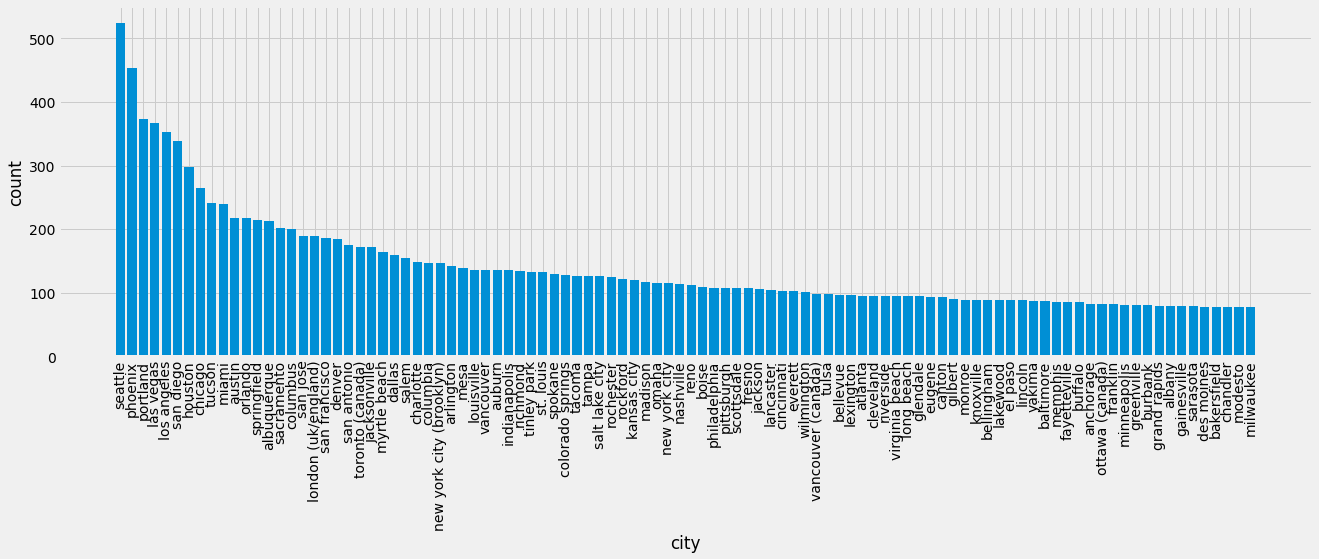

In [ ]:
with plt.style.context("fivethirtyeight"):
    plt.figure(figsize=(20,6))
    plt.bar(df_city.head(100)["city"], df_city.head(100)["country"])
    plt.xticks(rotation=90)
    plt.xlabel("city")
    plt.ylabel("count")

#UFO SHAPE

In [ ]:
# groupby city
df_shape = pd.DataFrame(data=df_s.groupby("shape").country.count()).reset_index().sort_values(by="country", ascending=False)
df_shape.head()

,shape,country
19,light,14628
27,triangle,7038
4,circle,6717
14,fireball,5526
28,unknown,4899


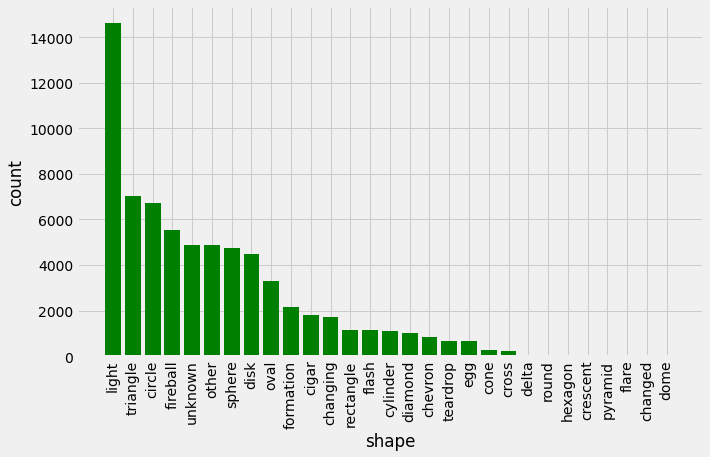

In [ ]:
with plt.style.context("fivethirtyeight"):
    plt.figure(figsize=(10,6))
    plt.bar(df_shape["shape"], df_shape["country"], color="green")
    plt.xticks(rotation=90)
    plt.xlabel("shape")
    plt.ylabel("count")

Almost light shape

Comment WordCloud

In [ ]:
# Fill null data of comments
df_s["comments"].fillna("no comment", inplace=True)

In [ ]:
text_in = []

for i in range(len(df_s)):
    text = re.sub(r'[^a-zA-Z]', ' ', df_s["comments"][i])
    text = text.lower()
    text = text.split()
               
    # PorterStemmer
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
               
    text_in.extend(text)

(-0.5, 399.5, 199.5, -0.5)

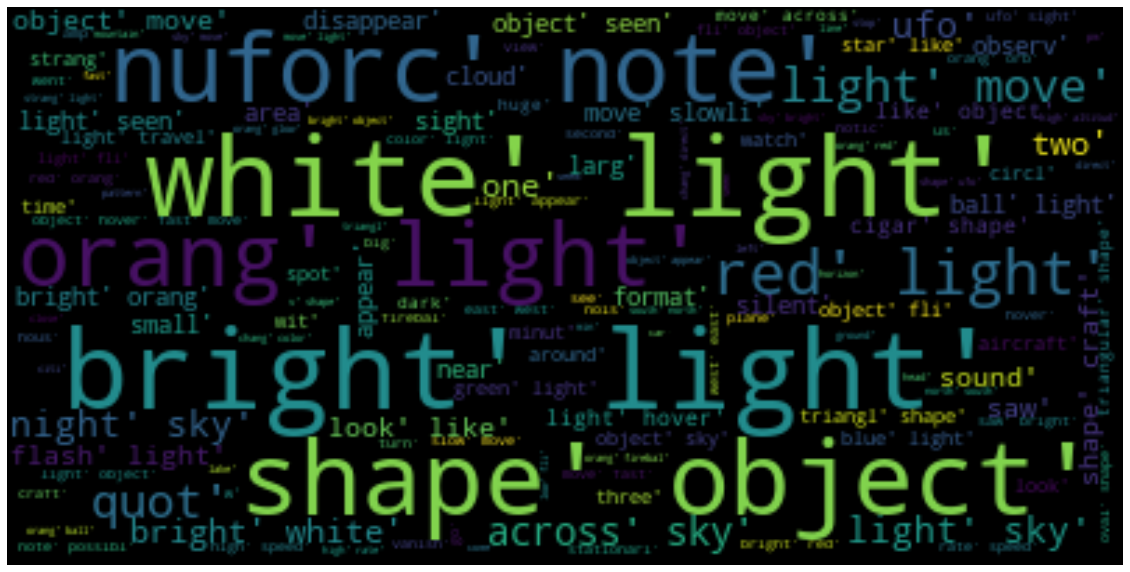

In [ ]:
# Create word cloud
wordcloud = WordCloud(background_color="black", max_words=300, max_font_size=40, random_state=10).generate(str(text_in))

plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")